# 1. Cargar los datos desde un archivo CSV

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler


# Cargar datos desde un archivo Excel
df = pd.read_excel('sample_data/Regresión Lineal Múltiple.xlsx')

# Variables predictoras y objetivo
X = df.drop(columns=['Sobrevivencia (días)'])
y = df['Sobrevivencia (días)']

#2. Escalar las variables predictoras usando MinMaxScaler

In [36]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convertir los datos escalados en un DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Mostrar las primeras filas de los datos escalados
print(X_scaled_df.head())

   Factor Coagulación  Índice pronóstico  Función de enzima  \
0            0.476744           0.593407           0.604167   
1            0.290698           0.560440           0.447917   
2            0.558140           0.538462           0.625000   
3            0.453488           0.714286           0.187500   
4            0.604651           0.626374           0.958333   

   Función de hígado   Edad  Género  Alcohol\n(moderado)  Alcohol\n(severo)  
0           0.326855  0.500     0.0                  1.0                0.0  
1           0.169611  0.225     0.0                  0.0                0.0  
2           0.250883  0.625     0.0                  0.0                0.0  
3           0.224382  0.450     0.0                  0.0                0.0  
4           0.628975  0.375     0.0                  0.0                1.0  


# 3. Realizar la regresión con las variables significativas

Model coefficients:  [-575.86374747  453.26085291  738.23244281  854.14304366  429.43164879
   25.63892773   13.09258075  -41.26764482  195.70703222]


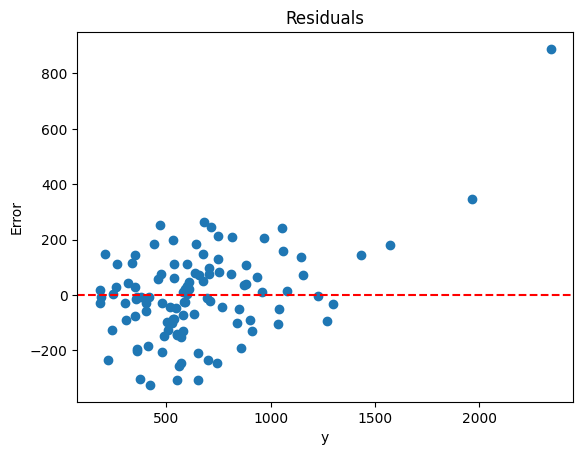

MSE:  26938.257179330714
MAE:  118.6071846460898
R^2:  0.775278095890658
Fold MSE =  68744.474620507
Fold MAE =  179.01633395719074
Fold R^2 =  0.5848207329411415
Fold MSE =  20637.99503886233
Fold MAE =  113.69004418757117
Fold R^2 =  0.6346586845530275
Fold MSE =  24736.697915983237
Fold MAE =  127.11137541880674
Fold R^2 =  0.8768907590702751
Fold MSE =  24912.6406715998
Fold MAE =  136.5562895149084
Fold R^2 =  0.785195352611537
Fold MSE =  19927.03524298255
Fold MAE =  106.99290601256723
Fold R^2 =  0.24292836688259
Average MSE: 31791.768697986983
Average MAE: 132.67338981820885
Average R^2: 0.6248987792117143


In [37]:
# Agregar la columna de unos para el intercepto
X_scaled = np.column_stack((np.ones(X_scaled.shape[0]), X_scaled))

# Definir funciones para ajustar el modelo y hacer predicciones
def fit_model(X, y):
    return np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y

def predict(X, beta):
    return X @ beta

# Ajustar el modelo usando los datos completos
beta = fit_model(X_scaled, y)
print("Model coefficients: ", beta)

# Hacer predicciones y evaluar residuos
y_pred = predict(X_scaled, beta)
r = y - y_pred

# Graficar residuos
plt.scatter(y, r)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('y')
plt.ylabel('Error')
plt.title('Residuals')
plt.show()

# Calcular MSE, MAE y R^2 con el conjunto de entrenamiento
print('MSE: ', mean_squared_error(y, y_pred))
print("MAE: ", mean_absolute_error(y, y_pred))
print("R^2: ", r2_score(y, y_pred))

# Evaluar el modelo con validación cruzada
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)

mse_cv = []
mae_cv = []
r2_cv = []

for train_index, test_index in kf.split(X_scaled):
    # Fase de entrenamiento
    X_train, X_test = X_scaled[train_index, :], X_scaled[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    beta_cv = fit_model(X_train, y_train)

    # Fase de prueba
    y_pred_cv = predict(X_test, beta_cv)

    # Calcular MSE, MAE y R^2
    mse_i = mean_squared_error(y_test, y_pred_cv)
    mse_cv.append(mse_i)

    mae_i = mean_absolute_error(y_test, y_pred_cv)
    mae_cv.append(mae_i)

    r2_i = r2_score(y_test, y_pred_cv)
    r2_cv.append(r2_i)

    print('Fold MSE = ', mse_i)
    print('Fold MAE = ', mae_i)
    print('Fold R^2 = ', r2_i)

print('Average MSE:', np.mean(mse_cv))
print('Average MAE:', np.mean(mae_cv))
print('Average R^2:', np.mean(r2_cv))


# 4. Probar si se deben agregar interacciones o términos polinomiales

# 5. Interpretar la tabla ANOVA, R², R² ajustada, p-values y FIV

In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Transformar las variables predictoras con MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convertir X_scaled a un DataFrame y agregar una constante para el intercepto
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df = sm.add_constant(X_scaled_df)

# Ajustar el modelo usando statsmodels
model = sm.OLS(y, X_scaled_df).fit()

# Mostrar resumen del modelo
print(model.summary())

# Evaluar factores de inflación de la varianza (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X_scaled_df)
print(vif_data)

# Interpretación:
# R^2, R^2 ajustado, p-values y VIF están en el resumen del modelo y en el DataFrame de VIF


                             OLS Regression Results                             
Dep. Variable:     Sobrevivencia (días)   R-squared:                       0.775
Model:                              OLS   Adj. R-squared:                  0.757
Method:                   Least Squares   F-statistic:                     42.69
Date:                  Tue, 03 Sep 2024   Prob (F-statistic):           8.70e-29
Time:                          23:32:04   Log-Likelihood:                -704.12
No. Observations:                   108   AIC:                             1426.
Df Residuals:                        99   BIC:                             1450.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

# 6. Verificar el cumplimiento de los supuestos

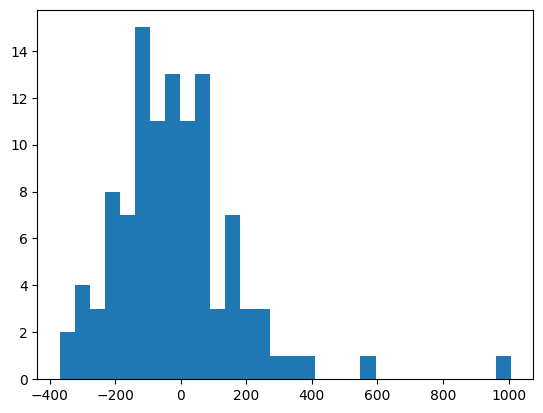

p-value Shapiro-Wilk: 4.3547291981843544e-07


In [24]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Histograma de los residuos
residuals = model.resid
plt.hist(residuals, bins=30)
plt.show()

# Prueba de normalidad
_, p_value = stats.shapiro(residuals)
print('p-value Shapiro-Wilk:', p_value)


**Homocedasticidad**

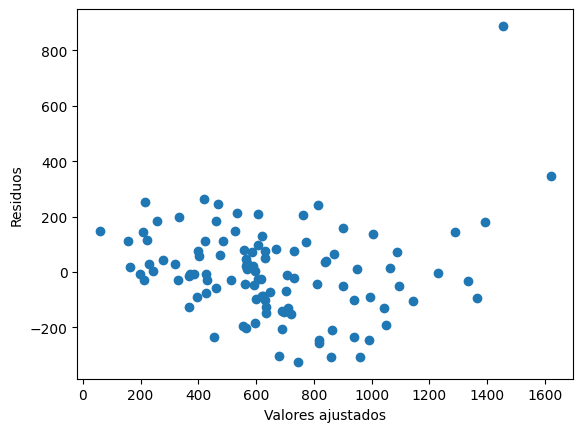

In [11]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

**Autocorrelación**

In [12]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(model.resid)
print('Durbin-Watson:', dw)

Durbin-Watson: 1.7702758663012679


**Realizar las transformaciones adecuadas a las variables predictoras.**

**Realizar el modelo de regresión con las variables significativas.**

**Probar si se deben agregar interacciones o términos polinomiales.**

**Interpretar la tabla ANOVA, R2, R2 ajustada, p-values y FIV.**

**Verificar el cumplimiento de los supuestos.**